<a href="https://colab.research.google.com/github/DeadlyPancakes45/Nucleus_detection/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#imports
import os
import zipfile


In [2]:
from google.colab import files
files.upload()  # This will prompt you to upload the file.


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tanmay2027","key":"1c336c4a9e7d7a91273a2b136d088223"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/


In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c data-science-bowl-2018

 99% 356M/358M [00:11<00:00, 38.3MB/s]
100% 358M/358M [00:11<00:00, 33.2MB/s]


In [ ]:
!ls -lh


total 359M
-rw-r--r-- 1 root root 359M Dec 11  2019  data-science-bowl-2018.zip
-rw-r--r-- 1 root root   66 Feb  7 15:01 'kaggle-2 (1).json'
-rw-r--r-- 1 root root   66 Feb  7 14:59  kaggle-2.json
drwxr-xr-x 1 root root 4.0K Feb  5 14:21  sample_data


In [6]:
!unzip data-science-bowl-2018.zip -d dsb2018/

Archive:  data-science-bowl-2018.zip
  inflating: dsb2018/stage1_sample_submission.csv.zip  
  inflating: dsb2018/stage1_solution.csv.zip  
  inflating: dsb2018/stage1_test.zip  
  inflating: dsb2018/stage1_train.zip  
  inflating: dsb2018/stage1_train_labels.csv.zip  
  inflating: dsb2018/stage2_sample_submission_final.csv.zip  
  inflating: dsb2018/stage2_test_final.zip  


In [7]:
!unzip dsb2018/stage1_train.zip -d stage1_train/
!unzip dsb2018/stage1_test.zip -d stage1_test/

Streaming output truncated to the last 5000 lines.
  inflating: stage1_train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/d86ee01921b1c9ed23c342952253682060512483c39c8b7b5c6d8350f6df2568.png  
  inflating: stage1_train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/d8b76279ad8f2e101bb8c5ca95229b6532903eea035ef945dd4a21356d49dead.png  
  inflating: stage1_train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/dc05f946c096c5fcc147024843f21c06c3a94af25d4f37b498ea937953b806fe.png  
  inflating: stage1_train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/e0fd1c4e98bb470bea315e7d8f74396450fe93e93f68e1f8a3443b2b397c8640.png  
  inflating: stage1_train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/e4b6643cafde8ac789b63f7b1a023773960dbe63489963985033619fde052dc9.png  
  inflating: stage1_train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/e7e793a1e178

In [8]:
import os

train_dir = "stage1_train/"
test_dir = "stage1_test/"

# List the first 5 patient folders
train_patients = os.listdir(train_dir)[:5]
print("Sample training patient folders:", train_patients)

# List images inside the first patient folder
if train_patients:
    image_path = os.path.join(train_dir, train_patients[0], "images")
    images = os.listdir(image_path)
    print("Images inside the first patient folder:", images)

Sample training patient folders: ['20e209f6ffa120a72712e1b4c1d3e24d1339227e2936abd4bbd49a636fada423', 'c15c652c08153fb781a5349123ab8f80bb2a8680a41eb8e89e547ae01b7a5441', '4d40de30a3db3bc4f241cb7f48e8497c11e8f20a99bf55788bdce17242029745', 'd4d6c683f249d82518431603bf0206d05f2114ac871a99ffade0f5f61cf167e1', 'ee927e8255096971ddae1bd975cf80c4ad7c847c82d0b5f5dd2ddfe5407007ee']
Images inside the first patient folder: ['20e209f6ffa120a72712e1b4c1d3e24d1339227e2936abd4bbd49a636fada423.png']


Displaying: stage1_train/20e209f6ffa120a72712e1b4c1d3e24d1339227e2936abd4bbd49a636fada423/images/20e209f6ffa120a72712e1b4c1d3e24d1339227e2936abd4bbd49a636fada423.png


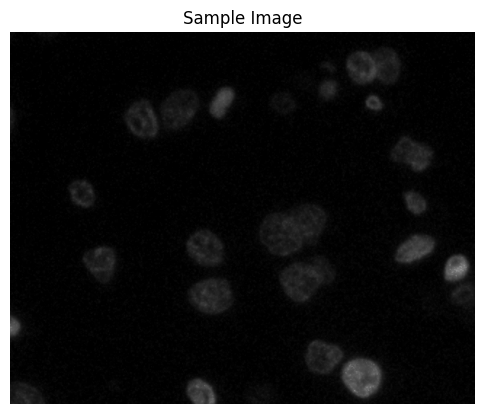

In [9]:
import cv2
import matplotlib.pyplot as plt

def display_image(image_path):
    """Loads and displays an image."""
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.axis("off")
        plt.title("Sample Image")
        plt.show()
    else:
        print("Error: Unable to load image.")

# Pick the first image from the dataset and display it
sample_image_path = os.path.join(train_dir, train_patients[0], "images", train_patients[0] + ".png")
print("Displaying:", sample_image_path)
display_image(sample_image_path)

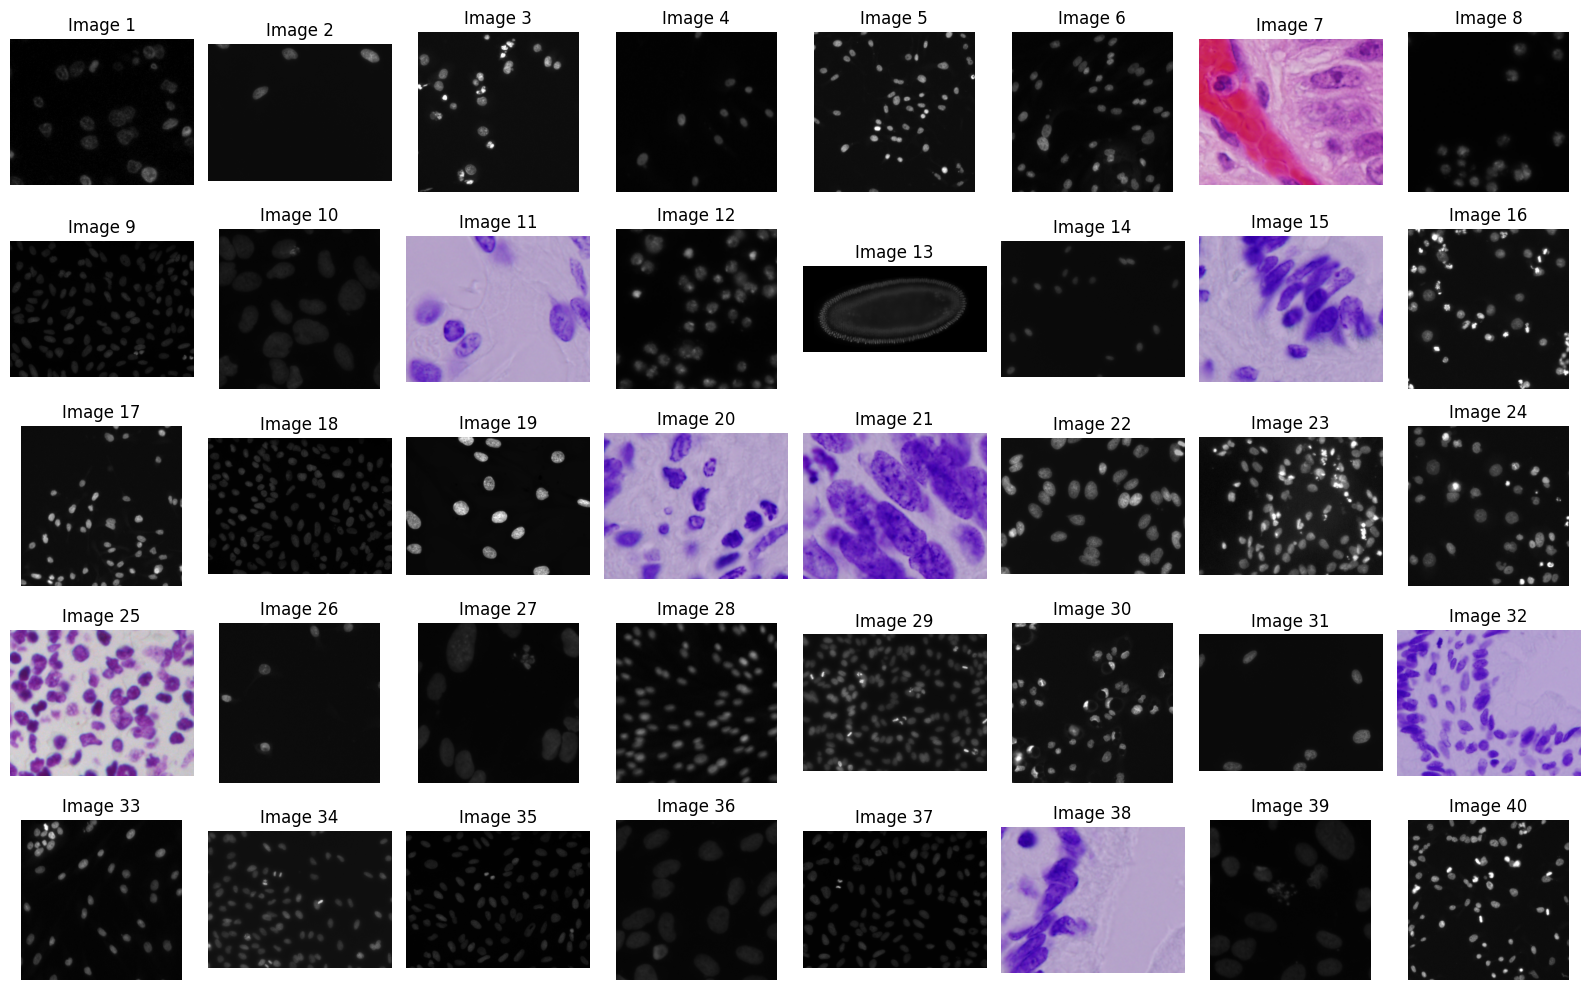

In [10]:
import os
import cv2
import math
import matplotlib.pyplot as plt
def display_multiple_images(image_paths, max_cols=8, max_images=40):
    """Dynamically display multiple images in a grid."""
    num_images = min(len(image_paths), max_images)
    rows = math.ceil(num_images / max_cols)
    cols = min(num_images, max_cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.ravel()
    for i in range(rows * cols):
        if i < num_images:
            image = cv2.imread(image_paths[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            axes[i].imshow(image)
            axes[i].axis("off")
            axes[i].set_title(f"Image {i+1}")
        else:
            axes[i].axis("off")
    plt.tight_layout()
    plt.show()


train_dir = "stage1_train"
train_patients = os.listdir(train_dir)
sample_images = [
    os.path.join(train_dir, patient, "images", patient + ".png")
    for patient in train_patients if os.path.exists(os.path.join(train_dir, patient, "images", patient + ".png"))
]
display_multiple_images(sample_images, max_cols=8, max_images=40)

In [ ]:
import os

dataset_path = os.path.join(os.getcwd(), "data_science_bowl_2018/")
print("Dataset Path:", dataset_path)

Dataset Path: /content/data_science_bowl_2018/


In [11]:
import os

dataset_path = "/content/stage1_train/"

if os.path.exists(dataset_path):
    print("✅ Dataset found!")
    print("Number of image folders:", len(os.listdir(dataset_path)))
else:
    print("❌ Dataset path is incorrect. Check the directory.")

✅ Dataset found!
Number of image folders: 670


In [12]:
!mkdir -p /content/data_science_bowl_2018
!mv /content/stage1_train /content/data_science_bowl_2018/
!mv /content/stage1_test /content/data_science_bowl_2018/
!mv /content/dsb2018 /content/data_science_bowl_2018/
!mv /content/data-science-bowl-2018.zip /content/data_science_bowl_2018/

In [13]:
import os

dataset_path = "/content/data_science_bowl_2018/"

if os.path.exists(dataset_path):
    print("✅ Dataset folder exists!")
    print("Contents of dataset folder:", os.listdir(dataset_path))
else:
    print("❌ Dataset folder not found. Check the directory.")

✅ Dataset folder exists!
Contents of dataset folder: ['data-science-bowl-2018.zip', 'stage1_test', 'stage1_train', 'dsb2018']


In [14]:
train_path = "/content/data_science_bowl_2018/stage1_train/"
test_path = "/content/data_science_bowl_2018/stage1_test/"
dsb_path = "/content/data_science_bowl_2018/dsb2018/"
zip_file = "/content/data_science_bowl_2018/data-science-bowl-2018.zip"

print("Train Path:", train_path)
print("Test Path:", test_path)
print("Other Files:", dsb_path, zip_file)

Train Path: /content/data_science_bowl_2018/stage1_train/
Test Path: /content/data_science_bowl_2018/stage1_test/
Other Files: /content/data_science_bowl_2018/dsb2018/ /content/data_science_bowl_2018/data-science-bowl-2018.zip


In [16]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm


dataset_path = "/content/data_science_bowl_2018/stage1_train/"


def mask_to_rle(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(map(str, runs))


rle_data = []


image_folders = os.listdir(dataset_path)
for folder in tqdm(image_folders, desc="Processing Images"):
    image_id = folder
    image_folder_path = os.path.join(dataset_path, folder)


    mask_paths = glob(os.path.join(image_folder_path, "masks", "*.png"))
    if not mask_paths:
        print(f"⚠️ No masks found for {image_id}, skipping...")
        continue


    masks = [cv2.imread(mask, cv2.IMREAD_GRAYSCALE) for mask in mask_paths]
    combined_mask = np.zeros_like(masks[0])
    for mask in masks:
        combined_mask = np.maximum(combined_mask, mask)


    combined_mask = (combined_mask > 0).astype(np.uint8)


    rle_encoded = mask_to_rle(combined_mask)


    rle_data.append([image_id, rle_encoded])


df = pd.DataFrame(rle_data, columns=["ImageId", "EncodedPixels"])
df.to_csv("rle_masks.csv", index=False)

print("✅ RLE mask encoding complete! CSV saved as 'rle_masks.csv'")

Processing Images: 100%|██████████| 670/670 [00:25<00:00, 26.59it/s]


✅ RLE mask encoding complete! CSV saved as 'rle_masks.csv'


In [18]:
dataset_path="/content/data_science_bowl_2018/stage1_train/"
csv_path="rle_masks.csv"
df=pd.read_csv(csv_path)
def rle_to_mask(rle,shape):
  s=list(map(int,rle.split()))
  starts=s[0::2]
  lengths=s[1::2]
  ends


In [31]:
abs_mask_path = os.path.abspath(mask_path)
print("Absolute path:", abs_mask_path)

Absolute path: /content/masks/rle_masks.csv


In [33]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from tensorflow.keras.utils import load_img, img_to_array

image_size = (256 // 2, 256 // 2)
dataset_path = "/content/data_science_bowl_2018/stage1_train/"
mask_path = "/content/masks/rle_masks.csv"
def load_data():
    image_paths = glob(os.path.join(dataset_path, "**", "images", "*.png"))
    images, masks = [], []

    for img_path in image_paths:
        image_id = img_path.split("/")[-3]
        mask_file = os.path.join(dataset_path, image_id, "masks", "*.png")
        mask_paths = glob(mask_file)

        if mask_paths:
            first_mask = cv2.imread(mask_paths[0], cv2.IMREAD_GRAYSCALE)
            h, w = first_mask.shape
            combined_mask = np.zeros((h, w), dtype=np.float32)

            for mask_path in mask_paths:
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if mask.shape != combined_mask.shape:
                    print(f"Skipping mask with shape {mask.shape} (expected {combined_mask.shape})")
                    continue
                combined_mask = np.maximum(combined_mask, mask)

            combined_mask = combined_mask / 255.0

            image = load_img(img_path, target_size=image_size)
            image = img_to_array(image) / 255.0

            if combined_mask.shape != (image_size[0], image_size[1]):
                combined_mask = cv2.resize(combined_mask, image_size)

            images.append(image)
            masks.append(combined_mask)

        else:
            print(f"No masks found for {image_id}, skipping...")

    return np.array(images), np.array(masks, dtype=np.float32)

X, Y = load_data()
Y = Y.reshape((Y.shape[0], image_size[0], image_size[1], 1))
print(f"{len(X)} images and {len(Y)} masks loaded successfully!")

670 images and 670 masks loaded successfully!


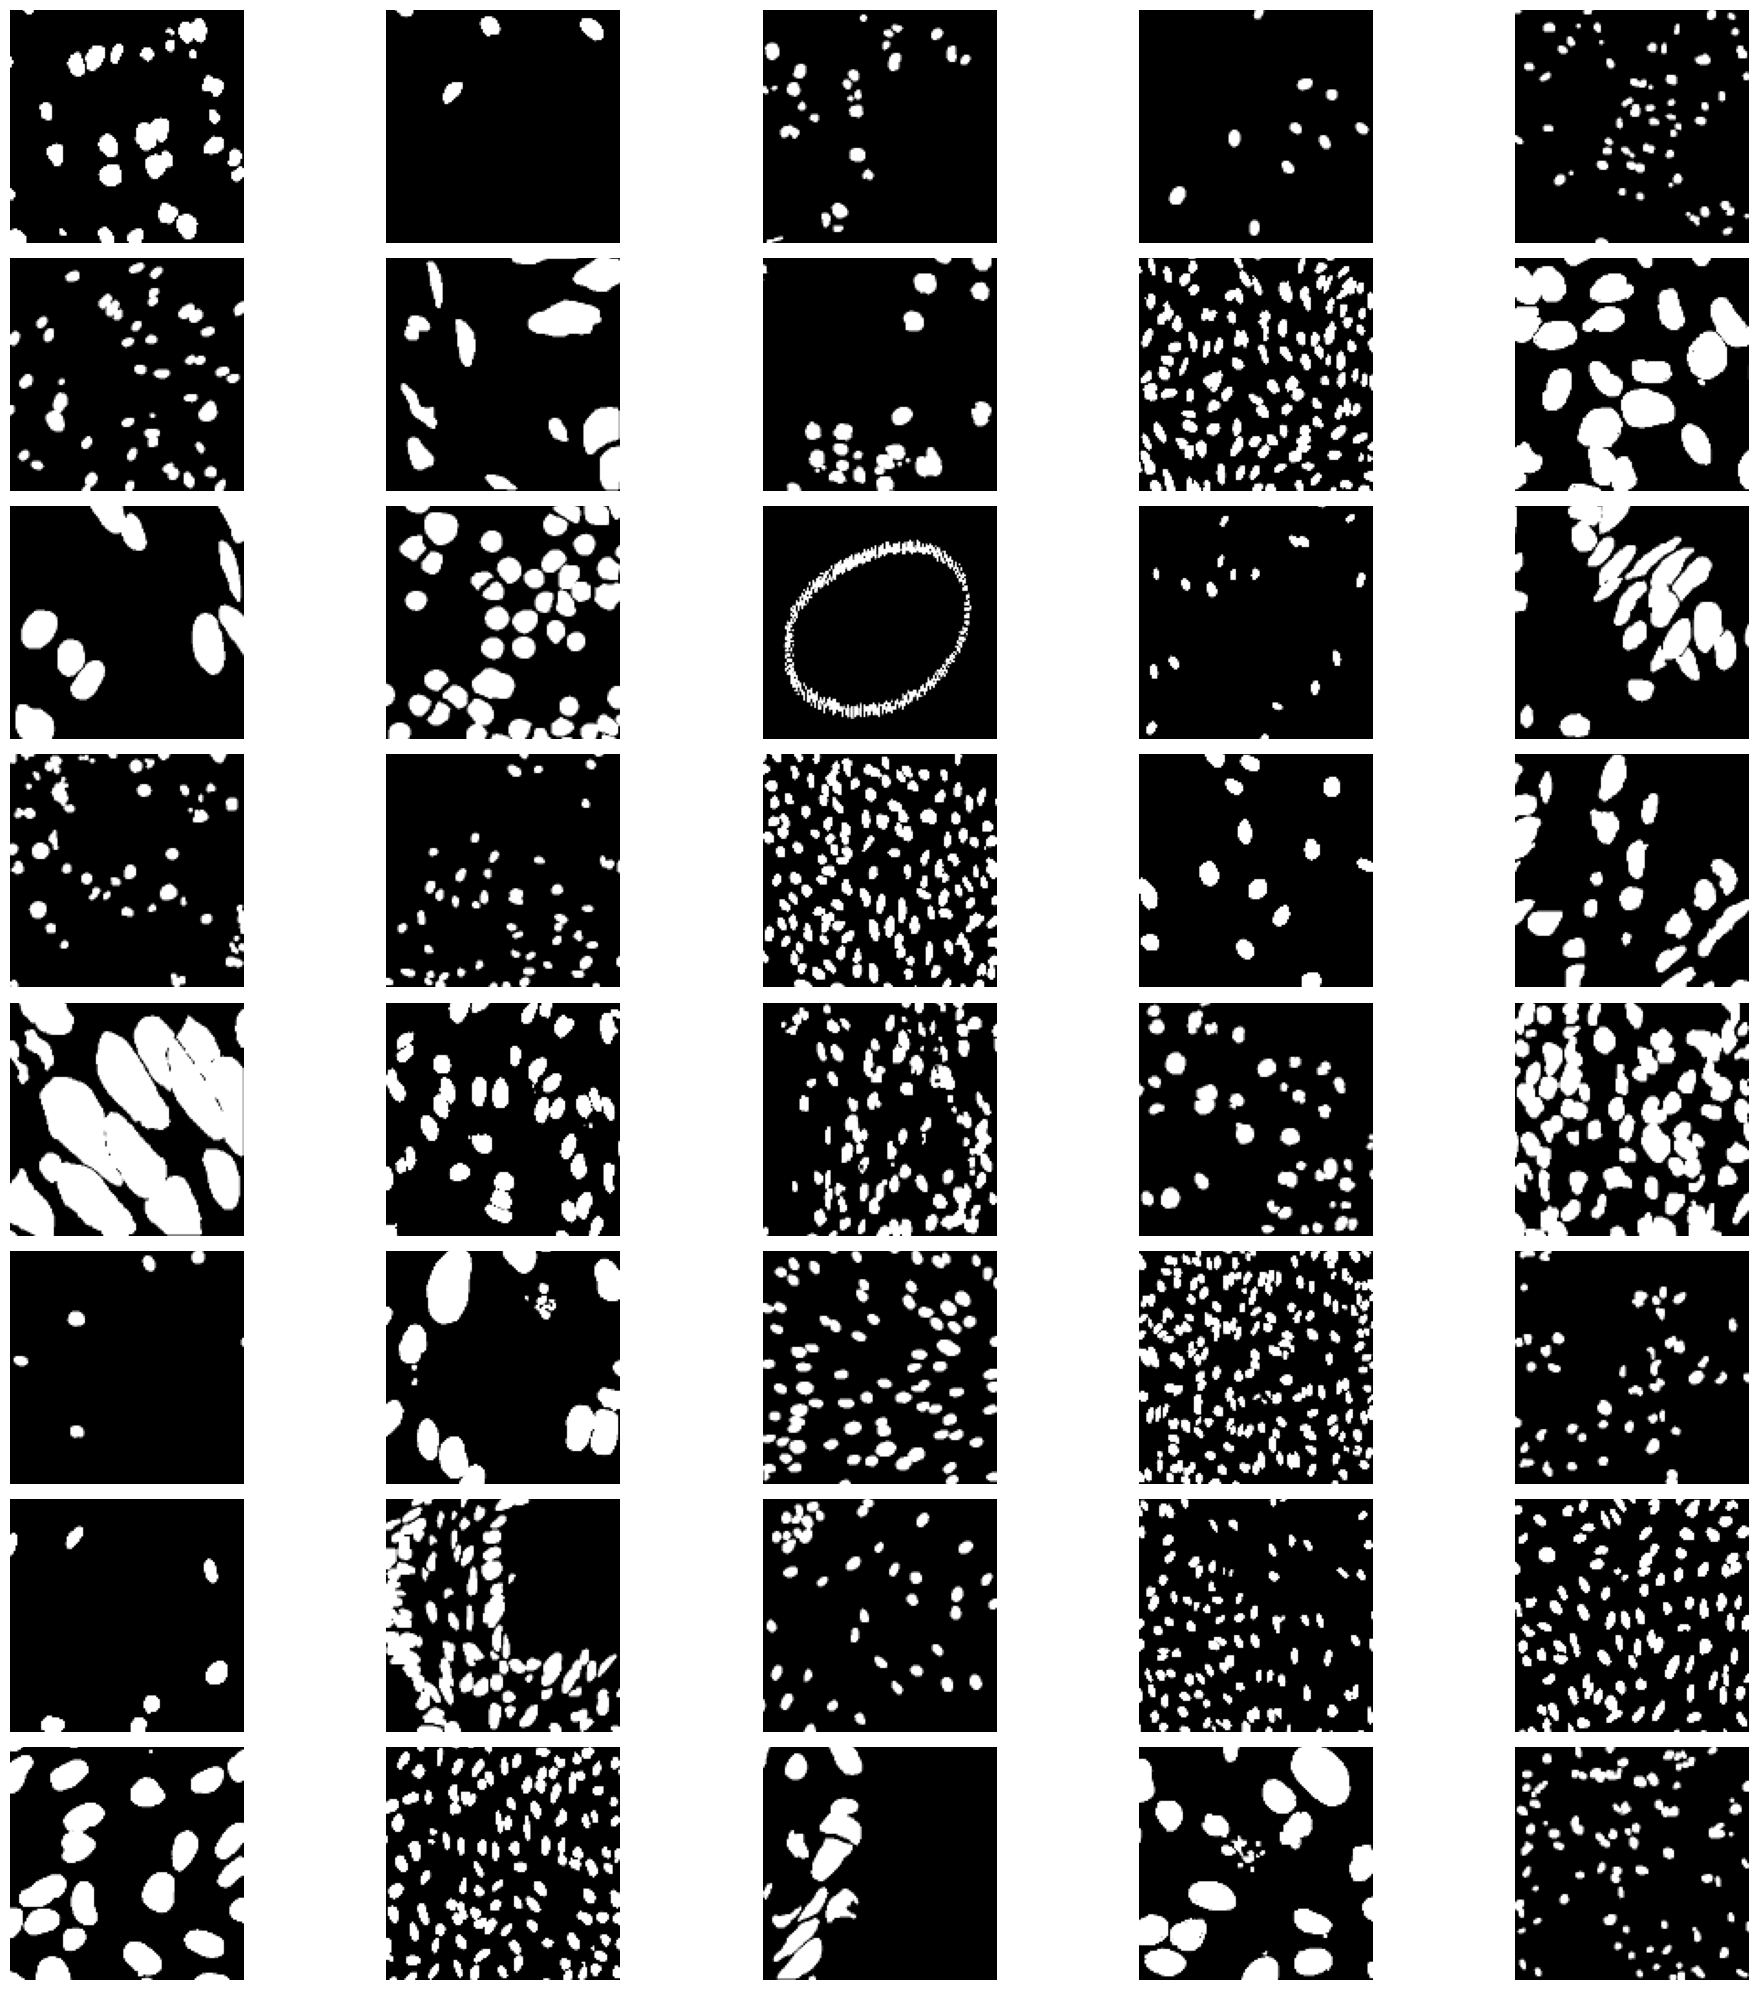

In [34]:
import matplotlib.pyplot as plt
def visualize_masks(masks, num_images=40, grid_shape=(8, 5)):
    num_rows, num_cols = grid_shape
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

    for i, ax in enumerate(axes.flat):
        if i >= num_images or i >= len(masks):
            ax.axis("off")
            continue
        ax.imshow(masks[i].squeeze(), cmap="gray")
        ax.axis("off")

    plt.tight_layout()
    plt.show()
visualize_masks(Y, num_images=40, grid_shape=(8, 5))

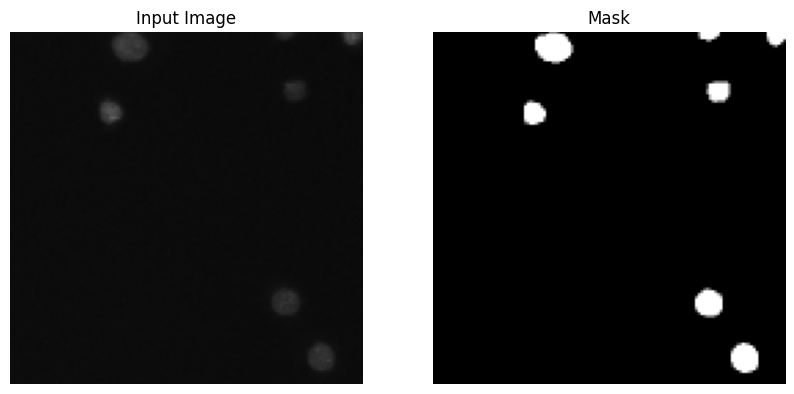

In [38]:
def visualize_sample(image, mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Mask")
    plt.axis("off")

    plt.show()
visualize_sample(X[669], Y[669].squeeze())

In [39]:
from keras.models import Model
from keras.layers import Input, Dropout,Lambda,Conv2D,Conv2DTranspose,MaxPooling2D,concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import backend as K




In [ ]:
smooth=1
def dice_coeff(y_true,y_pred):
  y_true_f=K.flatten(y_true)
  y_pred_f=K.flatten(y_pred)
  intersection=K.sum(y_true_f*y_pred_f)
  return (2.0*intersection+smooth)/(K.sum(y_true_f)+K.sum(y_pred_f)+smooth)